# Load combined data csv file

In [1]:
# pip install numpy==1.19.5  <-- needed numpy 1.19.5 to run LSTM function

In [2]:
# import all necessary libraries
import requests
import json
import sqlite3 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [3]:
print(np.__version__)

1.19.5


In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

In [5]:
# import FB Prophet libraries
from fbprophet import Prophet as proph
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric

In [6]:
# import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import median_absolute_error

In [7]:
# import LSTM libraries
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
import itertools

In [9]:
# this is not necessary but helps to run notebook faster
%config Completer.use_jedi = False

In [10]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [11]:
#Clear warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
# Set styles of visualizations
sns.set_style('darkgrid')
sns.set_context('poster')

In [13]:
pd.set_option("display.max_columns", 50)

In [14]:
combined = pd.read_csv('data/combined.csv')

In [15]:
# drop column 'Unnamed: 0'
combined.drop(columns=['Unnamed: 0'], inplace=True)

In [16]:
combined.shape

(26665, 28)

In [17]:
# change column 'Sale Date' to datetime
combined['sale_date'] = pd.to_datetime(combined['sale_date'], infer_datetime_format=True)

In [18]:
combined.columns

Index(['sale_date', 'item_name', 'quantity', 'transaction_id', 'listing_id',
       'ship_city', 'ship_state', 'ship_zipcode', 'ship_country', 'order_id',
       'variations', 'state', 'user_id', 'category_id', 'title', 'description',
       'tags', 'shop_section_id', 'featured_rank', 'views', 'num_favorers',
       'occasion', 'style', 'is_customizable', 'has_variations', 'taxonomy_id',
       'taxonomy_path', 'main_tag'],
      dtype='object')

# Modeling for Category 1 data

In [19]:
cat_data = combined[combined.main_tag == 'cat_1'].groupby('sale_date')['quantity'].sum()

In [20]:
cat_data = pd.DataFrame(cat_data)

In [21]:
len(cat_data)

348

Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [22]:
cat_data.sum()

quantity    3399
dtype: int64

In [23]:
dates = pd.date_range(start='2020-01-01', end='2020-12-31')
type(dates)

pandas.core.indexes.datetimes.DatetimeIndex

In [24]:
dates = pd.DataFrame(dates)

In [25]:
dates.columns = ['sale_date']

In [26]:
cat_data = pd.merge(left=dates, right=cat_data, on='sale_date', how='left')

In [27]:
cat_data.isna().sum()

sale_date     0
quantity     18
dtype: int64

In [28]:
cat_data.sum()

quantity    3399.0
dtype: float64

In [29]:
cat_data.fillna(0, inplace=True)

In [30]:
cat_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   quantity   366 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.6 KB


In [31]:
cat_data.set_index('sale_date', inplace=True)

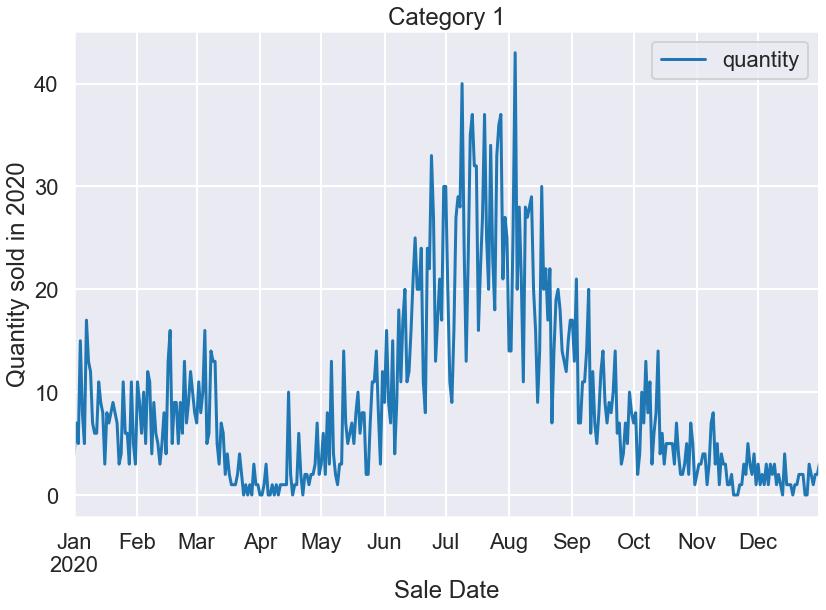

In [32]:
fig, ax = plt.subplots(figsize = (12,9))
cat_data.plot(ax=ax, legend=True)
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
fig.tight_layout()
plt.savefig('images/cat1_chart.jpeg', format='jpeg');

### Train test split the data

In [33]:
cat_data_train = cat_data[:round(len(cat_data) * 0.8)]
cat_data_test = cat_data[round(len(cat_data) * 0.8):]
cat_data_test.shape

(73, 1)

### Load external data

In [34]:
cat_API = pd.read_csv('data/party_decorations_API.csv')

In [35]:
cat_API.shape

(366, 6)

In [36]:
# change column 'Sale Date' to datetime
cat_API['date'] = pd.to_datetime(cat_API['date'], infer_datetime_format=True)

In [37]:
cat_API.head()

,date,unscaled,monthly,isPartial,scale,cat
0,2020-01-01,36,0.0,0,0.00,0.00
1,2020-01-02,100,0.0,0,0.00,0.00
2,2020-01-03,78,0.0,0,0.00,0.00
3,2020-01-04,87,0.0,0,0.00,0.00
4,2020-01-05,54,82.0,False,0.82,44.28


Looks like there were days when this category hasn't been bought. Need to fill in the missing dates with 0

In [38]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [39]:
dates.head()

,sale_date
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05


In [40]:
cat_API = pd.merge(left=dates, right=cat_API, left_on='sale_date', right_on='date', how='left')

In [41]:
cat_API.isna().sum()

sale_date    0
date         0
unscaled     0
monthly      0
isPartial    0
scale        0
cat          0
dtype: int64

In [42]:
cat_API.sum()

unscaled                                                 23888
monthly                                                  22855
isPartial    0000False000000False000000False000000False0000...
scale                                                   228.55
cat                                                    15414.3
dtype: object

In [43]:
cat_API.fillna(0, inplace=True)

In [44]:
cat_API.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   sale_date  366 non-null    datetime64[ns]
 1   date       366 non-null    datetime64[ns]
 2   unscaled   366 non-null    int64         
 3   monthly    366 non-null    float64       
 4   isPartial  366 non-null    object        
 5   scale      366 non-null    float64       
 6   cat        366 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(1), object(1)
memory usage: 22.9+ KB


In [45]:
cat_API.set_index('date', inplace=True)  # was 'sale_date'

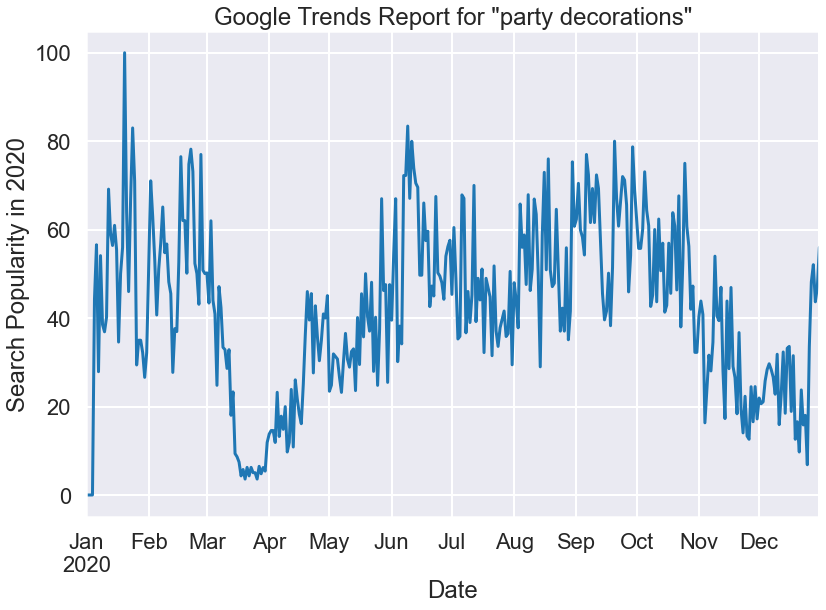

In [46]:
fig, ax = plt.subplots(figsize = (12,9))
cat_API.cat.plot(ax=ax)  
plt.title('Google Trends Report for "party decorations"')
plt.xlabel('Date')
plt.ylabel('Search Popularity in 2020')
fig.tight_layout()
plt.savefig('images/cat1_API_chart.jpeg', format='jpeg');

### Train test split the external data

In [47]:
cat_API_train = cat_API[:round(len(cat_API) * 0.8)]
cat_API_test = cat_API[round(len(cat_API) * 0.8):]
cat_API_test.shape

(73, 6)

## FB Prophet model

In [48]:
# let's calculate the maximum amount in any category bought in one day. Plus 25 as a buffer. We'll need this 
# later to establish cap and floor in logistic Prophet
max_cap = combined.groupby(['main_tag', 'sale_date'])['quantity'].sum().max() + 25
max_cap

100

### Rename the columns

In [49]:
cat_data.reset_index(inplace=True)

In [50]:
# Prophet needs the date column to be named 'ds' and the target column to be named 'y' for it to run
cat_proph = cat_data.rename(columns={'sale_date': 'ds',
                                         'quantity': 'y'})
cat_proph.tail()

,ds,y
361,2020-12-27,2.0
362,2020-12-28,1.0
363,2020-12-29,2.0
364,2020-12-30,2.0
365,2020-12-31,3.0


In [51]:
# We need to specify a carrying capacity in order to utilize a saturating minimum later
cat_proph['cap'] = max_cap

# Let's specify a saturating minimum, so our model doesn't predict below it.
cat_proph['floor'] = 0

### Train test split the data

In [52]:
cat_proph_train = cat_proph[:round(len(cat_data) * 0.8)]
cat_proph_test = cat_proph[round(len(cat_data) * 0.8):]
cat_proph_test.shape

(73, 4)

### Linear Prophet model (monthly)

In [53]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cat_proph.add_country_holidays(country_name='US')

In [54]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')

In [56]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

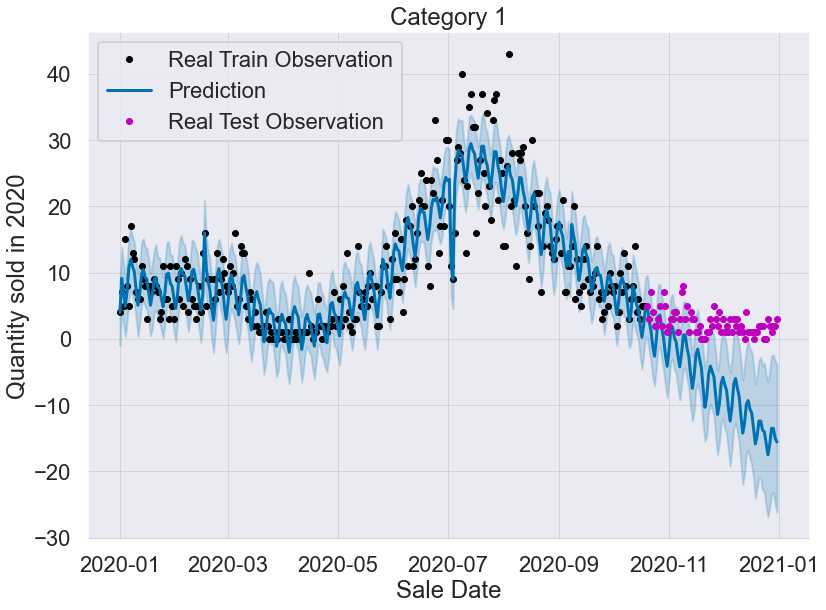

In [57]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/lin_prophet_mo.jpeg', format='jpeg');

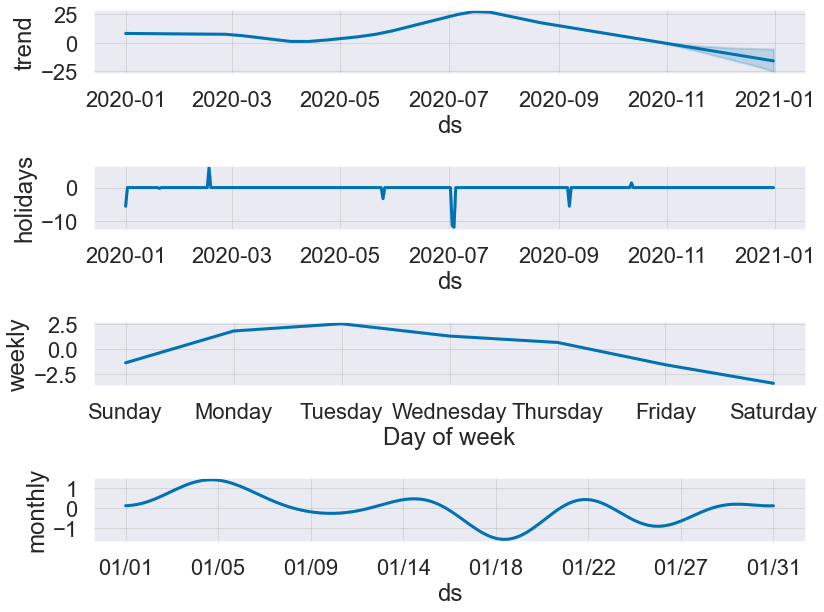

In [58]:
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/lin_prophet_mo_components.jpeg', format='jpeg');

In [59]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [60]:
# calculate train / test MAE and RMSE
lin_proph_train_mae = mean_absolute_error(y_train, y_train_pred)
lin_proph_mae = mean_absolute_error(y_test, y_pred)
print('Monthly Linear Prophet train MAE: {:.2f}'.format(lin_proph_train_mae))
print('Monthly Linear Prophet test MAE: {:.2f}'.format(lin_proph_mae))
print('\n')
lin_proph_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
lin_proph_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Monthly Linear Prophet train RMSE: {:.2f}'.format(lin_proph_train_rmse))
print('Monthly Linear Prophet test RMSE: {:.2f}'.format(lin_proph_rmse))

Monthly Linear Prophet train MAE: 3.12
Monthly Linear Prophet test MAE: 9.04


Monthly Linear Prophet train RMSE: 4.07
Monthly Linear Prophet test RMSE: 10.36


### Logistic Prophet model (monthly)

In [61]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cat_proph.add_country_holidays(country_name='US')

In [62]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [63]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [64]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

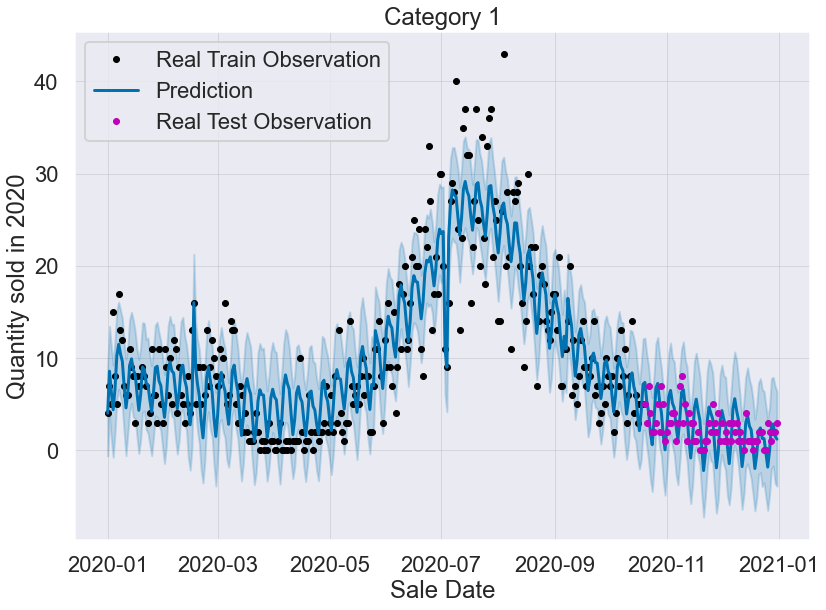

In [65]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_mo.jpeg', format='jpeg');

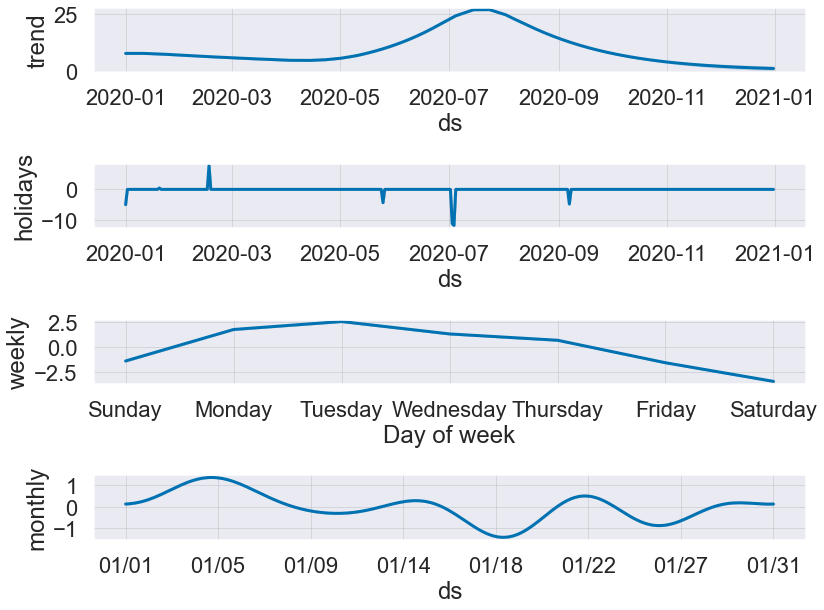

In [66]:
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_mo_components.jpeg', format='jpeg');

In [67]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [68]:
# calculate train / test MAE and RMSE
log_proph_train_mae = mean_absolute_error(y_train, y_train_pred)
log_proph_mae = mean_absolute_error(y_test, y_pred)
print('Monthly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae))
print('Monthly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae))
print('\n')
log_proph_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Monthly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse))
print('Monthly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse))

Monthly Logistic Prophet train MAE: 3.39
Monthly Logistic Prophet test MAE: 2.01


Monthly Logistic Prophet train RMSE: 4.29
Monthly Logistic Prophet test RMSE: 2.35


### Weekly Logistic Prophet model

In [69]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='weekly', period=7, fourier_order=3) # this line could be commented out
model_cat_proph.add_country_holidays(country_name='US')

In [70]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [71]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [72]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

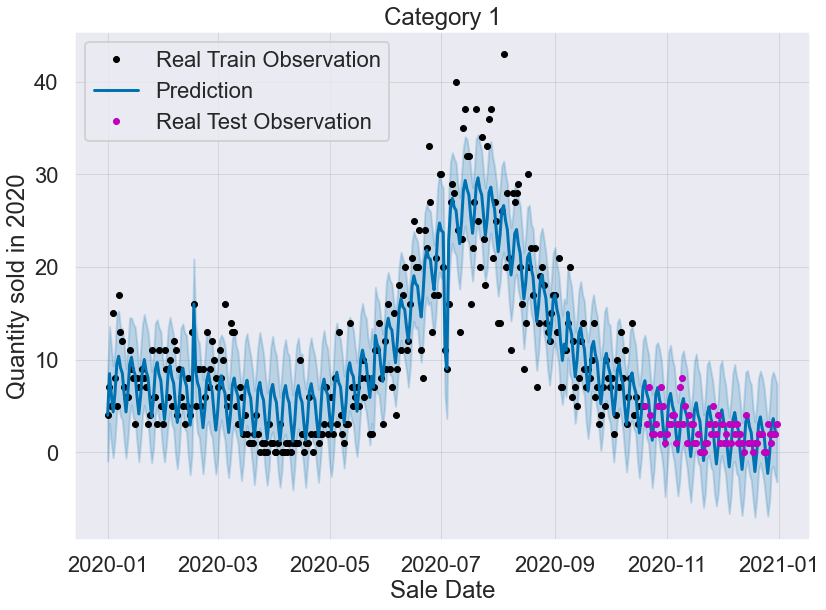

In [73]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_wk.jpeg', format='jpeg');

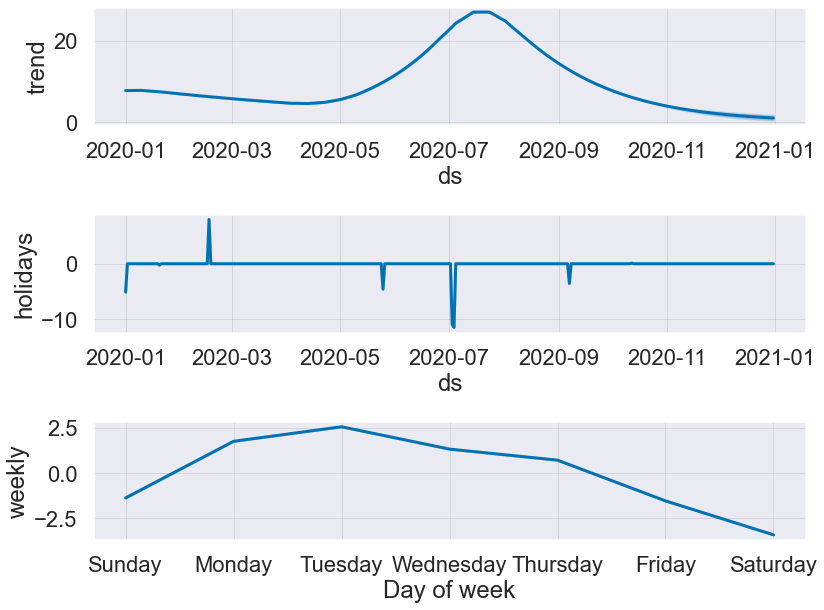

In [74]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_wk_components.jpeg', format='jpeg');

In [75]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [76]:
# calculate train / test MAE and RMSE
log_proph_train_mae_weekly = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_weekly = mean_absolute_error(y_test, y_pred)
print('Weekly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae_weekly))
print('Weekly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae_weekly))
print('\n')
log_proph_train_rmse_weekly = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_weekly = np.sqrt(mean_squared_error(y_test, y_pred))
print('Weekly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse_weekly))
print('Weekly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse_weekly))

Weekly Logistic Prophet train MAE: 3.43
Weekly Logistic Prophet test MAE: 1.94


Weekly Logistic Prophet train RMSE: 4.34
Weekly Logistic Prophet test RMSE: 2.31


### Quarterly Logistic Prophet model

In [77]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='quarterly', period=91, fourier_order=7)
model_cat_proph.add_country_holidays(country_name='US')

In [78]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [79]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [80]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

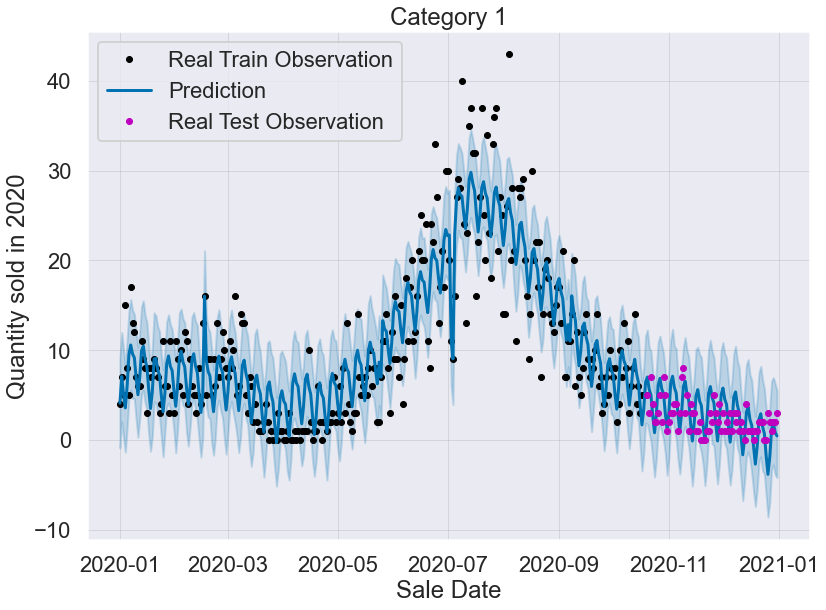

In [81]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_qtr.jpeg', format='jpeg');

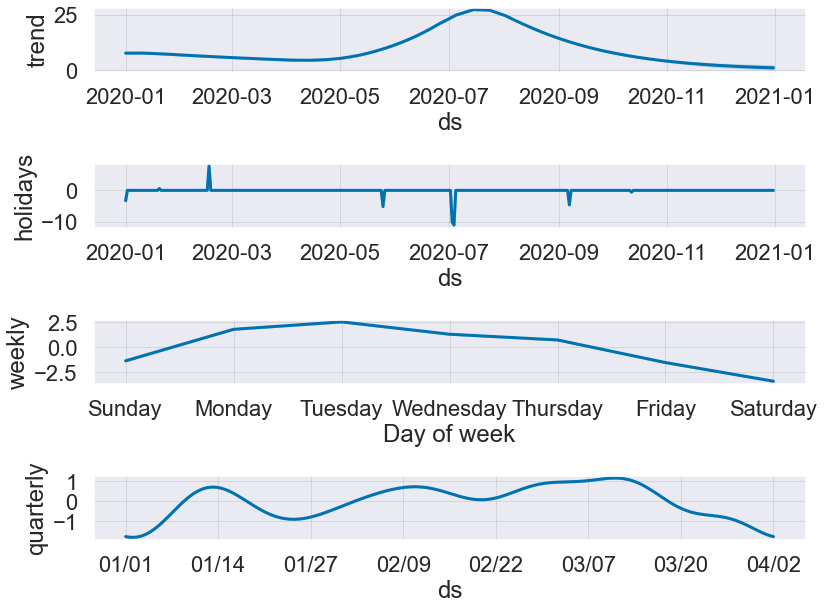

In [82]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_qtr_components.jpeg', format='jpeg');

In [83]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [84]:
# calculate train / test MAE and RMSE
log_proph_train_mae_qtr = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_qtr = mean_absolute_error(y_test, y_pred)
print('Quarterly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae_qtr))
print('Quarterly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae_qtr))
print('\n')
log_proph_train_rmse_qtr = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_qtr = np.sqrt(mean_squared_error(y_test, y_pred))
print('Quarterly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse_qtr))
print('Quarterly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse_qtr))

Quarterly Logistic Prophet train MAE: 3.32
Quarterly Logistic Prophet test MAE: 2.07


Quarterly Logistic Prophet train RMSE: 4.26
Quarterly Logistic Prophet test RMSE: 2.46


If we had access to data for multiple years, we could have tried Logistic Prophet model with yearly seasonality. 

### Yearly Logistic Prophet model

In [85]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='yearly', period=365, fourier_order=10)
model_cat_proph.add_country_holidays(country_name='US')

In [86]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [87]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [88]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

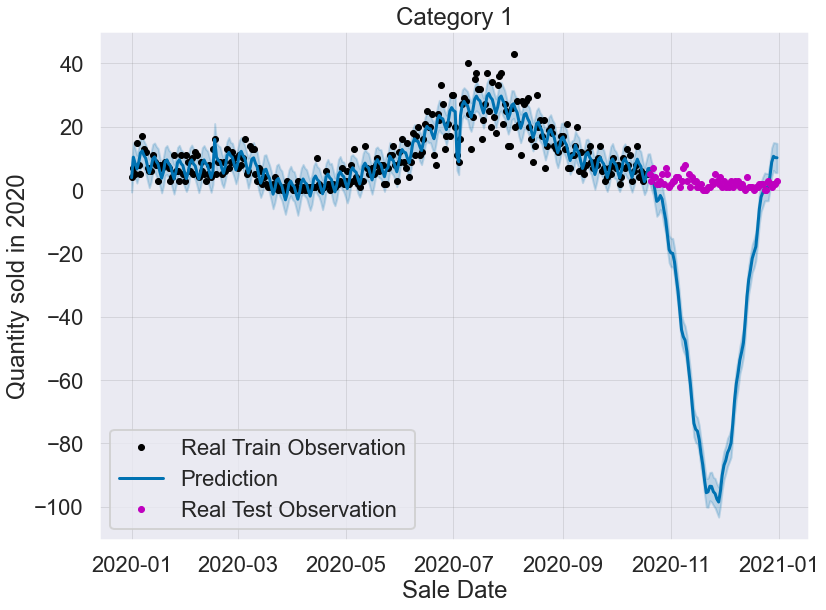

In [89]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_yr.jpeg', format='jpeg');

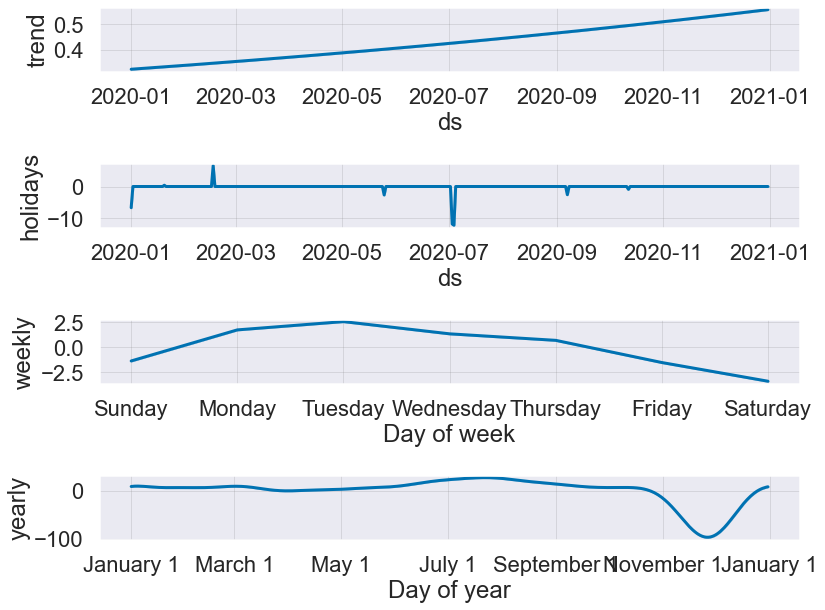

In [90]:
# plot the trend
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_yr_components.jpeg', format='jpeg');

In [91]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [92]:
# calculate train / test MAE and RMSE
log_proph_train_mae_yrly = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_yrly = mean_absolute_error(y_test, y_pred)
print('Yearly Logistic Prophet train MAE: {:.2f}'.format(log_proph_train_mae_yrly))
print('Yearly Logistic Prophet test MAE: {:.2f}'.format(log_proph_mae_yrly))
print('\n')
log_proph_train_rmse_yrly = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_yrly = np.sqrt(mean_squared_error(y_test, y_pred))
print('Yearly Logistic Prophet train RMSE: {:.2f}'.format(log_proph_train_rmse_yrly))
print('Yearly Logistic Prophet test RMSE: {:.2f}'.format(log_proph_rmse_yrly))

Yearly Logistic Prophet train MAE: 2.98
Yearly Logistic Prophet test MAE: 45.78


Yearly Logistic Prophet train RMSE: 3.94
Yearly Logistic Prophet test RMSE: 57.56


### Comparison

In [93]:
# compare Prophet train /test MAE and RMSE scores
print('Monthly Logistic Prophet train MAE: %.3f' % log_proph_train_mae)
print('Monthly Logistic Prophet test MAE: %.3f' % log_proph_mae)
print('\n')
print('Weekly Logistic Prophet train MAE: %.3f' % log_proph_train_mae_weekly)
print('Weekly Logistic Prophet test MAE: %.3f' % log_proph_mae_weekly)
print('\n')
print('Quarterly Logistic Prophet train MAE: %.3f' % log_proph_train_mae_qtr)
print('Quarterly Logistic Prophet test MAE: %.3f' % log_proph_mae_qtr)
print('\n')
print('Yearly Logistic Prophet train MAE: %.3f' % log_proph_train_mae_yrly)
print('Yearly Logistic Prophet test MAE: %.3f' % log_proph_mae_yrly)
print('\n')

print('Monthly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse)
print('Monthly Logistic Prophet test RMSE: %.3f' % log_proph_rmse)
print('\n')
print('Weekly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse_weekly)
print('Weekly Logistic Prophet test RMSE: %.3f' % log_proph_rmse_weekly)
print('\n')
print('Quarterly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse_qtr)
print('Quarterly Logistic Prophet test RMSE: %.3f' % log_proph_rmse_qtr)
print('\n')
print('Yearly Logistic Prophet train RMSE: %.3f' % log_proph_train_rmse_yrly)
print('Yearly Logistic Prophet test RMSE: %.3f' % log_proph_rmse_yrly)

Monthly Logistic Prophet train MAE: 3.394
Monthly Logistic Prophet test MAE: 2.009


Weekly Logistic Prophet train MAE: 3.430
Weekly Logistic Prophet test MAE: 1.943


Quarterly Logistic Prophet train MAE: 3.315
Quarterly Logistic Prophet test MAE: 2.071


Yearly Logistic Prophet train MAE: 2.985
Yearly Logistic Prophet test MAE: 45.778


Monthly Logistic Prophet train RMSE: 4.290
Monthly Logistic Prophet test RMSE: 2.345


Weekly Logistic Prophet train RMSE: 4.345
Weekly Logistic Prophet test RMSE: 2.307


Quarterly Logistic Prophet train RMSE: 4.255
Quarterly Logistic Prophet test RMSE: 2.461


Yearly Logistic Prophet train RMSE: 3.939
Yearly Logistic Prophet test RMSE: 57.557


## Additional: (Exo) Monthly Logistic Prophet model

Let's try adding exogenous variable to Prophet model.

In [94]:
cat_proph_train['external'] = cat_API_train.cat.values

In [95]:
# Set the parameters for the model. Make sure to include proper seasonality 
# Use a relatively high changepoint_prior_scale for a flexible trend, as our data varies wildly day-to-day
# Set a high forier_order to fit more quickly-changing and complex seasonality patterns.
# Make sure seasonality is set to monthly so we get a monthly breakdown in our plot_components
# Add holidays as they are either open and sell well or closed during some of them
model_cat_proph = proph(growth='logistic', interval_width=.75, weekly_seasonality=True, changepoint_prior_scale=.5)
model_cat_proph.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_cat_proph.add_country_holidays(country_name='US')
model_cat_proph.add_regressor('external') # add exogenous variable

In [96]:
# Fit the model to our train data
model_cat_proph_fit = model_cat_proph.fit(cat_proph_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [97]:
# create test_dates variable that extends to 2020/12/31
test_dates = model_cat_proph.make_future_dataframe(periods=73, freq='D')
test_dates['cap'] = max_cap
test_dates['floor'] = 0

In [98]:
test_dates['external'] = cat_API.cat.values

In [99]:
# predict up to 2020/12/31
forecast_cat_test = model_cat_proph_fit.predict(test_dates)

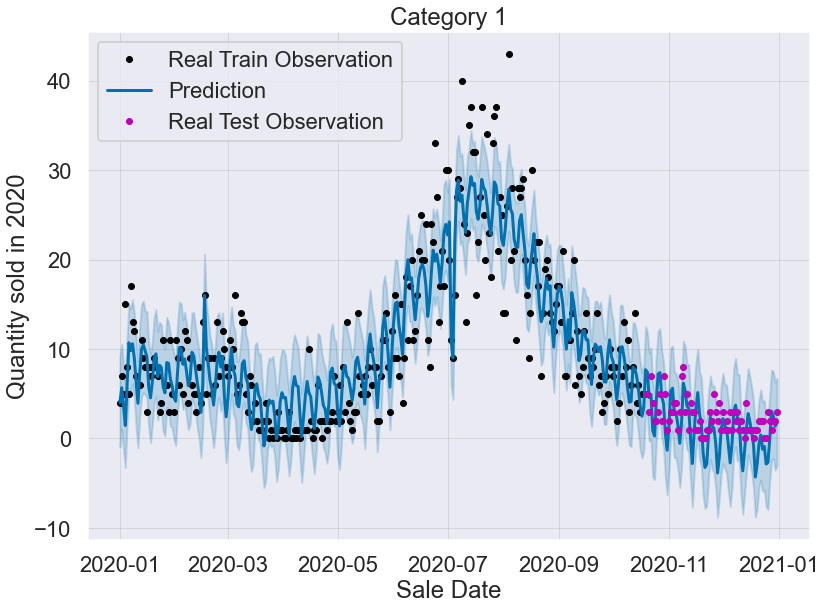

In [100]:
# plot the forecast
fig, ax = plt.subplots(figsize = (12,9))
model_cat_proph.plot(forecast_cat_test, uncertainty=True, plot_cap=False, ax=ax)
ax.plot(cat_proph_test.ds, cat_proph_test.y, color='m', marker='.', linestyle='')
plt.title('Category 1')
plt.xlabel('Sale Date')
plt.ylabel('Quantity sold in 2020')
plt.legend(('Real Train Observation', 'Prediction', 'Real Test Observation'))
fig.tight_layout()
plt.savefig('images/log_prophet_mo_exo.jpeg', format='jpeg');

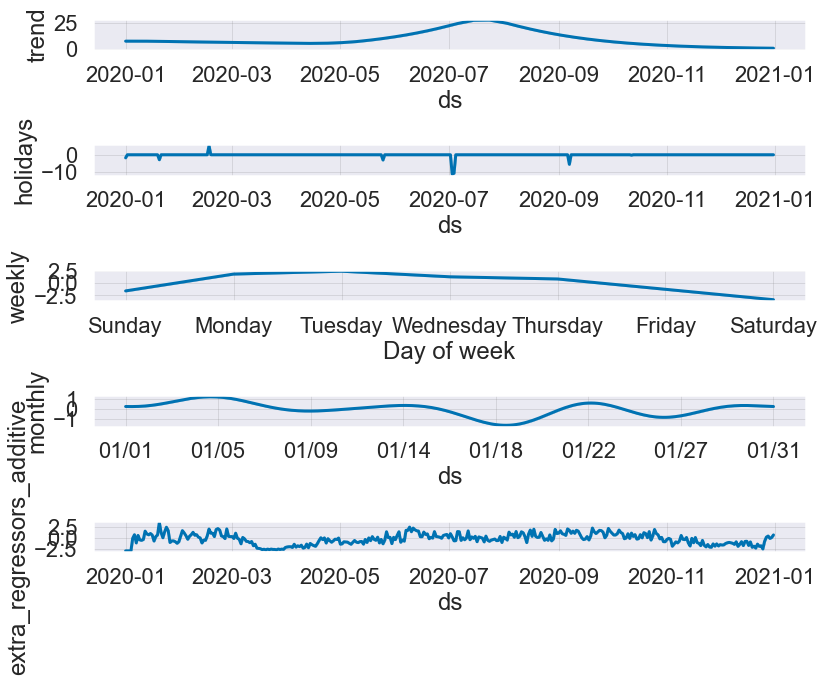

In [101]:
# Use plot_components to see the overall, holiday, weekly, and monthly trends
model_cat_proph.plot_components(forecast_cat_test, figsize=(12,9), plot_cap=False)
plt.savefig('images/log_prophet_mo_exo_components.jpeg', format='jpeg');

In [102]:
# set up train and test datasets for calculating MAE and RMSE
y_train = cat_proph_train['y'].values
y_test = cat_proph_test['y'].values
y_train_pred = forecast_cat_test[:-73]['yhat'].values
y_pred = forecast_cat_test[-73:]['yhat'].values

In [103]:
# calculate train / test MAE and RMSE
log_proph_train_mae_exo = mean_absolute_error(y_train, y_train_pred)
log_proph_mae_exo = mean_absolute_error(y_test, y_pred)
print('Monthly Logistic Prophet with an Additional Regressor train MAE: {:.2f}'.format(log_proph_train_mae_exo))
print('Monthly Logistic Prophet with an Additional Regressor test MAE: {:.2f}'.format(log_proph_mae_exo))
print('\n')
log_proph_train_rmse_exo = np.sqrt(mean_squared_error(y_train, y_train_pred))
log_proph_rmse_exo = np.sqrt(mean_squared_error(y_test, y_pred))
print('Monthly Logistic Prophet with an Additional Regressor train RMSE: {:.2f}'.format(log_proph_train_rmse_exo))
print('Monthly Logistic Prophet with an Additional Regressor test RMSE: {:.2f}'.format(log_proph_rmse_exo))

Monthly Logistic Prophet with an Additional Regressor train MAE: 3.31
Monthly Logistic Prophet with an Additional Regressor test MAE: 2.35


Monthly Logistic Prophet with an Additional Regressor train RMSE: 4.22
Monthly Logistic Prophet with an Additional Regressor test RMSE: 2.83
